<a href="https://colab.research.google.com/github/anjithababuraj/CognoRise/blob/main/SuperStore_Sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

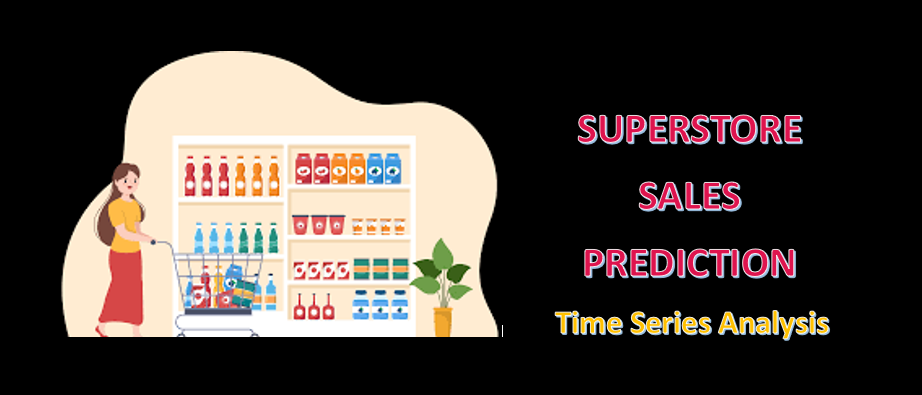

In [99]:
# import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import warnings

In [100]:
# Set configurations for plotting and warnings
col_pal = sns.color_palette("deep")
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

In [101]:
# Load the dataset
data = pd.read_csv('/content/train.csv')

In [102]:
data.shape

(9800, 18)

In [103]:
data.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [104]:
data.tail()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
9795,9796,CA-2017-125920,21/05/2017,28/05/2017,Standard Class,SH-19975,Sally Hughsby,Corporate,United States,Chicago,Illinois,60610.0,Central,OFF-BI-10003429,Office Supplies,Binders,"Cardinal HOLDit! Binder Insert Strips,Extra St...",3.798
9796,9797,CA-2016-128608,12/01/2016,17/01/2016,Standard Class,CS-12490,Cindy Schnelling,Corporate,United States,Toledo,Ohio,43615.0,East,OFF-AR-10001374,Office Supplies,Art,"BIC Brite Liner Highlighters, Chisel Tip",10.368
9797,9798,CA-2016-128608,12/01/2016,17/01/2016,Standard Class,CS-12490,Cindy Schnelling,Corporate,United States,Toledo,Ohio,43615.0,East,TEC-PH-10004977,Technology,Phones,GE 30524EE4,235.188
9798,9799,CA-2016-128608,12/01/2016,17/01/2016,Standard Class,CS-12490,Cindy Schnelling,Corporate,United States,Toledo,Ohio,43615.0,East,TEC-PH-10000912,Technology,Phones,Anker 24W Portable Micro USB Car Charger,26.376
9799,9800,CA-2016-128608,12/01/2016,17/01/2016,Standard Class,CS-12490,Cindy Schnelling,Corporate,United States,Toledo,Ohio,43615.0,East,TEC-AC-10000487,Technology,Accessories,SanDisk Cruzer 4 GB USB Flash Drive,10.384


In [105]:
# Convert 'Order Date' to datetime
data['Order Date'] = pd.to_datetime(data['Order Date'], format='%d/%m/%Y')

In [106]:
# Display minimum and maximum dates in the dataset
min_date = data['Order Date'].min()
max_date = data['Order Date'].max()
print(min_date)
print(max_date)
print(max_date - min_date)

2015-01-03 00:00:00
2018-12-30 00:00:00
1457 days 00:00:00


In [107]:
# Drop unnecessary columns that are not needed for time series analysis
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
        'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name']
data.drop(cols, axis=1, inplace=True)

In [108]:
# Sort data by 'Order Date' and aggregate sales
data = data.sort_values('Order Date')
data = data.groupby('Order Date')['Sales'].sum().reset_index()
data = data.set_index('Order Date')
data.index = pd.to_datetime(data.index)

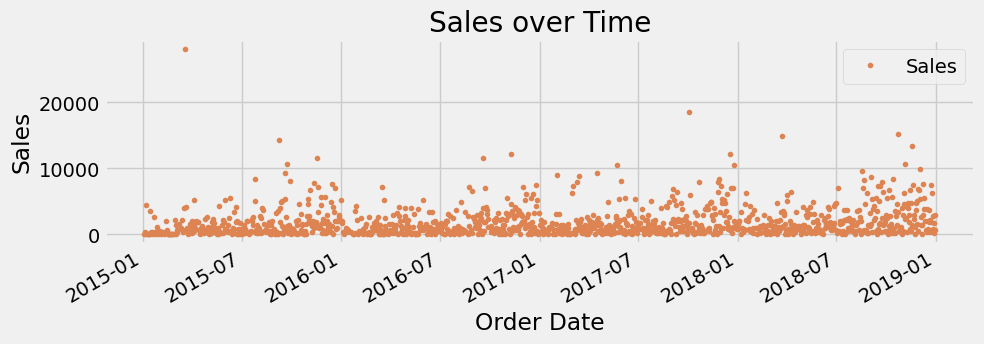

In [109]:
# Plot sales over time to visualize the trend
data.plot(style='.', figsize=(10, 3), color=col_pal[1], title='Sales over Time')
plt.ylabel('Sales')
plt.xlabel('Order Date')
plt.show()

In [110]:
# Split the data into training and testing sets based on the date
train = data.loc[data.index < '2018-01-01']
test = data.loc[data.index >= '2018-01-01']

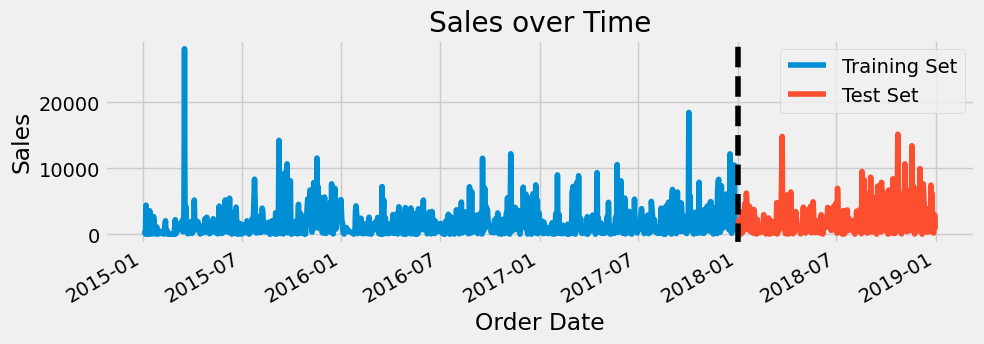

In [111]:
# Plot training and test sets to visualize the split
fig, ax = plt.subplots(figsize=(10, 3))
train.plot(ax=ax, label='Training Set')
test.plot(ax=ax, label='Test Set')
ax.axvline('2018-01-01', color='black', ls='--')
ax.set_ylabel('Sales')
ax.set_xlabel('Order Date')
ax.set_title('Sales over Time')
ax.legend(['Training Set', 'Test Set'])
plt.show()

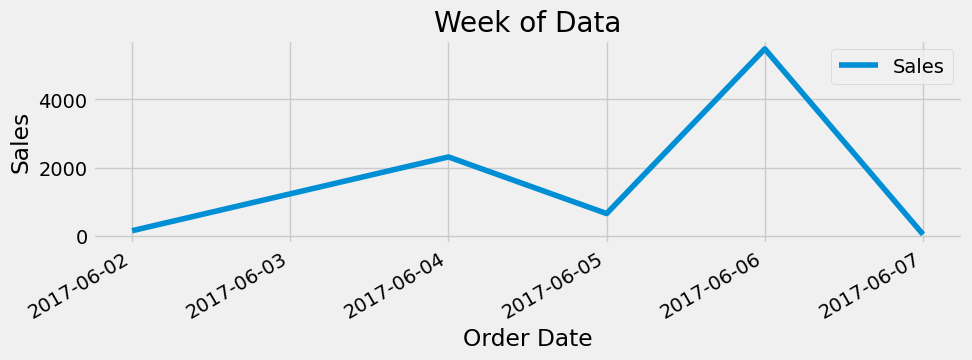

In [112]:
# Plot a week of data to inspect the sales trend within a week
data.loc[(data.index > '2017-06-01') & (data.index < '2017-06-08')].plot(figsize=(10, 3), title='Week of Data')
plt.ylabel('Sales')
plt.xlabel('Order Date')
plt.show()

In [113]:
# Function to create time series features from the datetime index
def create_features(data):
    "Create Time Series Features"
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    data['quarter'] = data.index.quarter
    data['month'] = data.index.month
    data['year'] = data.index.year
    data['dayofyear'] = data.index.dayofyear
    data['dayofmonth'] = data.index.day
    return data

In [114]:
# Create time series features for the entire dataset
data = create_features(data)
features = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth']
target = 'Sales'

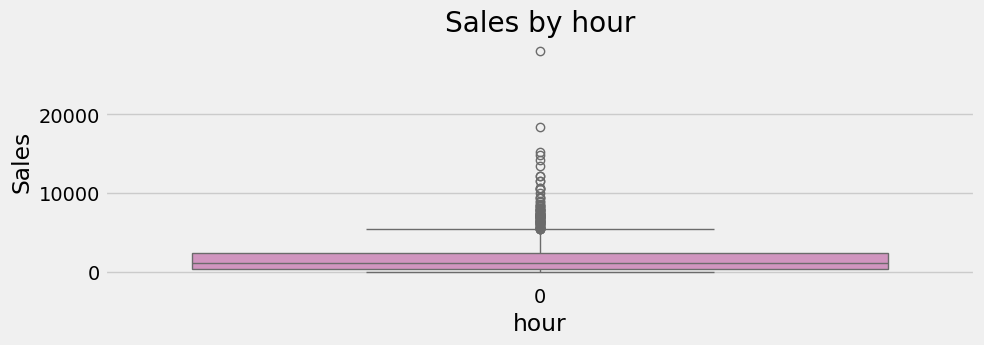

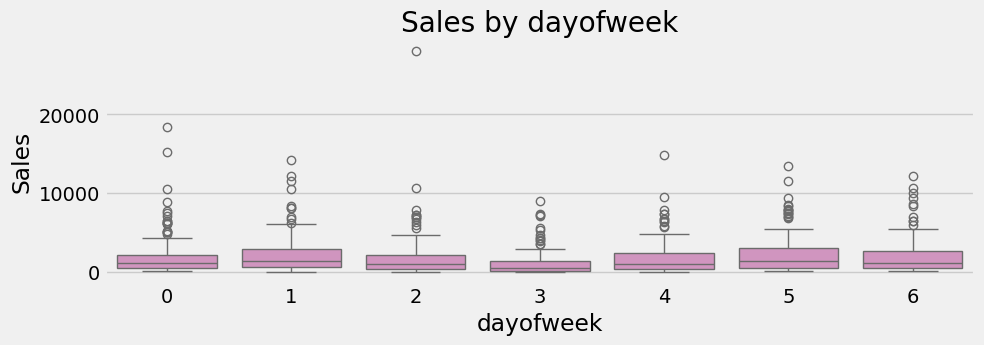

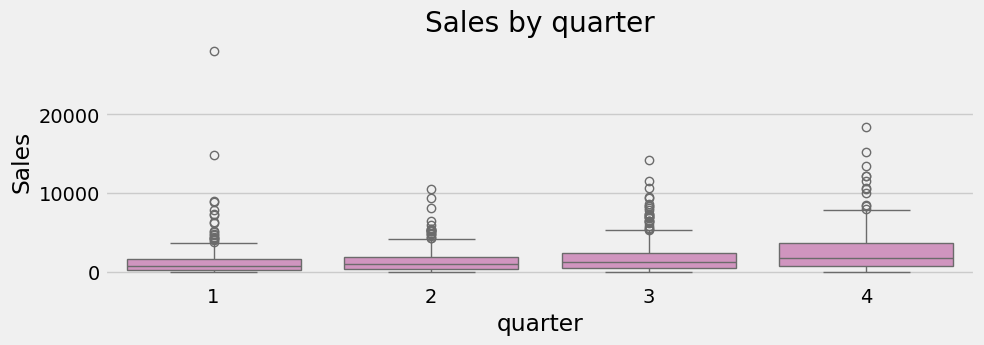

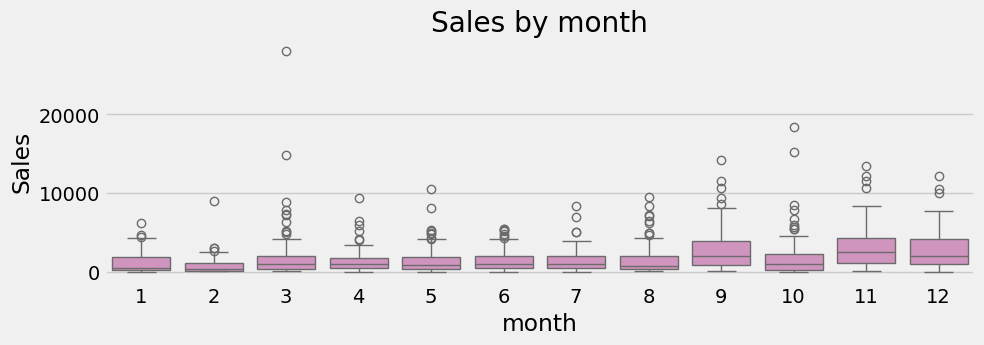

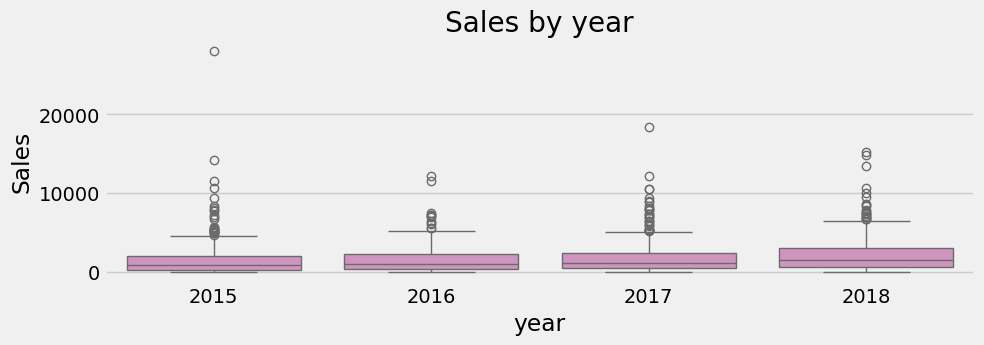

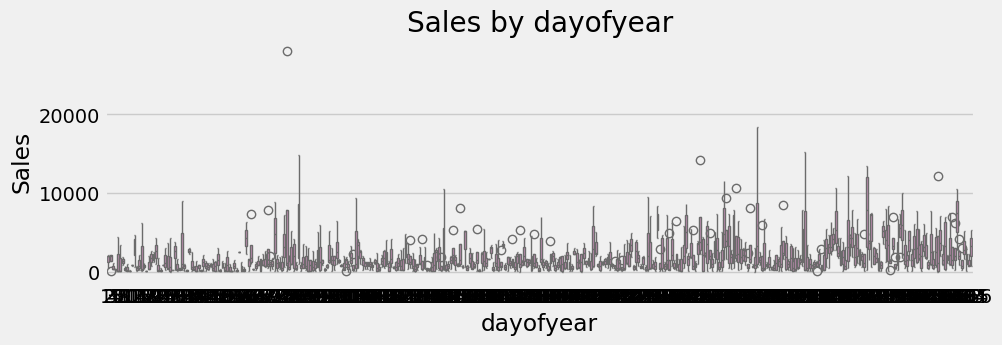

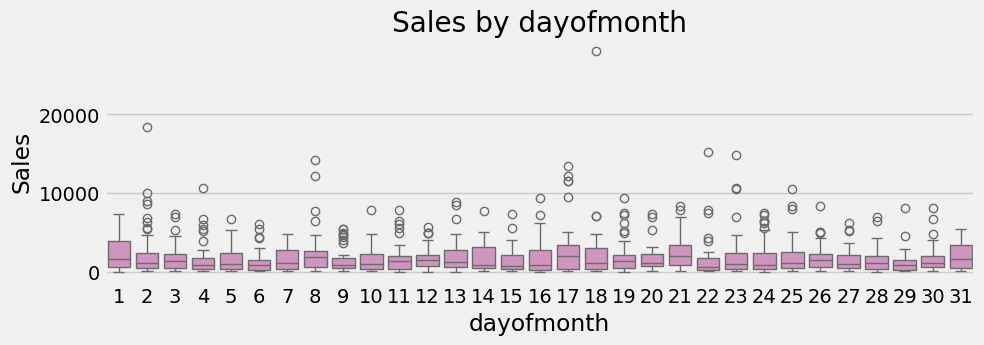

In [115]:
# Plot sales by each feature to explore their relationships
for i in features:
    fig, ax = plt.subplots(figsize=(10, 3))
    sns.boxplot(data=data, x=i, y='Sales', ax=ax, color=col_pal[6])
    ax.set_title('Sales by ' + i)
    plt.show()

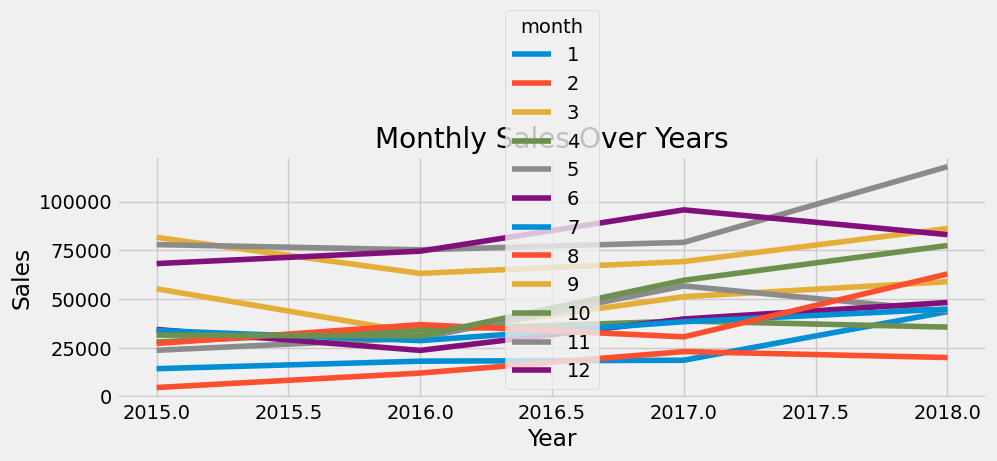

In [116]:
# Create additional visualizations

# Sales by Month and Year
fig, ax = plt.subplots(figsize=(10, 3))
data.groupby(['year', 'month'])['Sales'].sum().unstack().plot(ax=ax)
ax.set_title('Monthly Sales Over Years')
plt.ylabel('Sales')
plt.xlabel('Year')
plt.show()

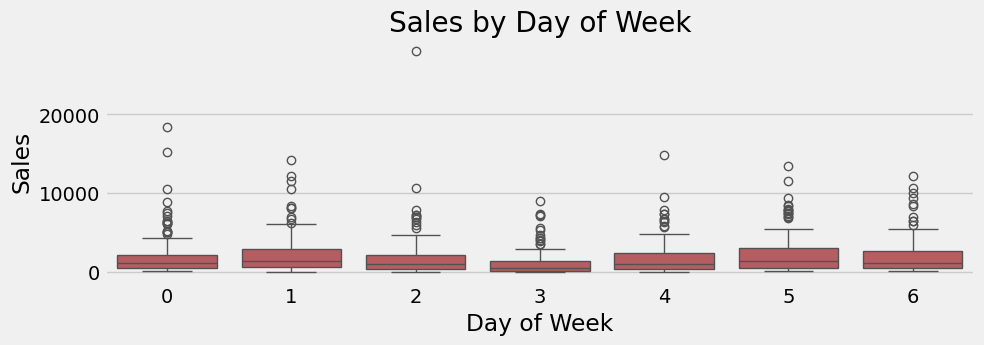

In [117]:
# Sales by Day of Week
fig, ax = plt.subplots(figsize=(10, 3))
sns.boxplot(data=data, x='dayofweek', y='Sales', ax=ax, color=col_pal[3])
ax.set_title('Sales by Day of Week')
plt.ylabel('Sales')
plt.xlabel('Day of Week')
plt.show()

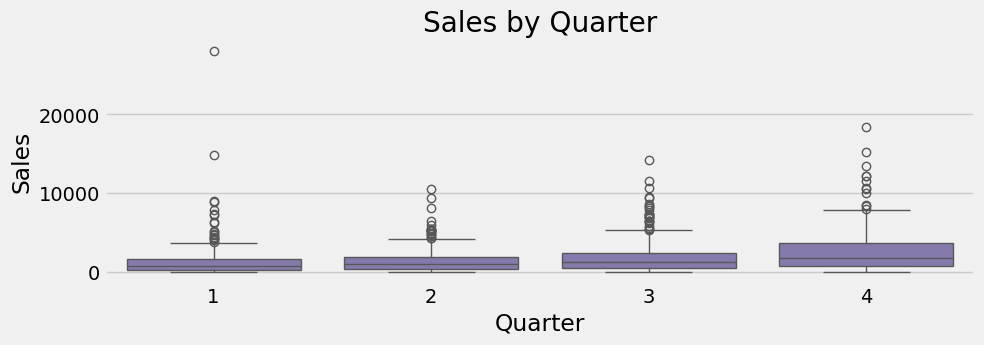

In [118]:
# Sales by Quarter
fig, ax = plt.subplots(figsize=(10, 3))
sns.boxplot(data=data, x='quarter', y='Sales', ax=ax, color=col_pal[4])
ax.set_title('Sales by Quarter')
plt.ylabel('Sales')
plt.xlabel('Quarter')
plt.show()

In [119]:
# Load original data again for segment, category, and sub-category analysis
data_original = pd.read_csv('/content/train.csv')
data_original['Order Date'] = pd.to_datetime(data_original['Order Date'], format='%d/%m/%Y')

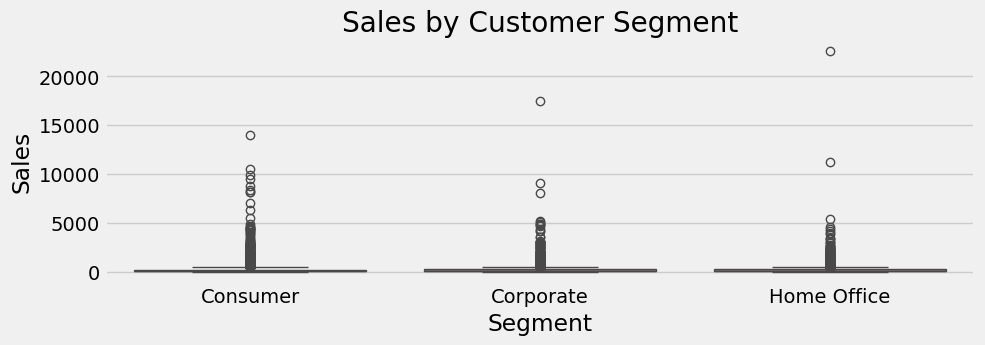

In [120]:
# Sales by Customer Segment
fig, ax = plt.subplots(figsize=(10, 3))
sns.boxplot(data=data_original, x='Segment', y='Sales', ax=ax, color=col_pal[5])
ax.set_title('Sales by Customer Segment')
plt.ylabel('Sales')
plt.xlabel('Segment')
plt.show()

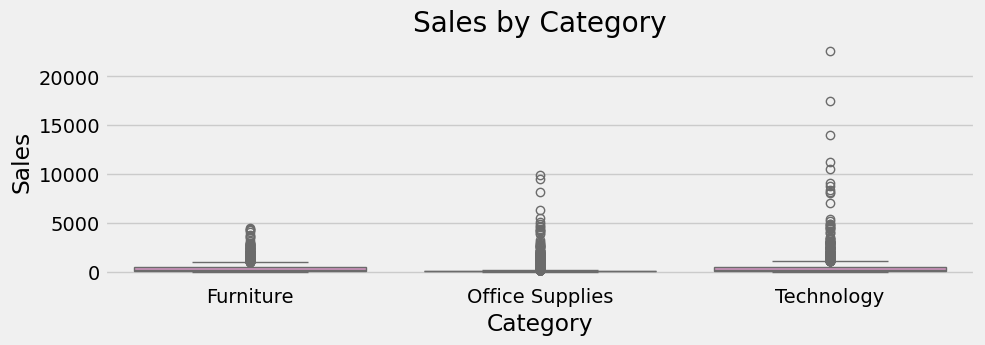

In [121]:
# Sales by Category
fig, ax = plt.subplots(figsize=(10, 3))
sns.boxplot(data=data_original, x='Category', y='Sales', ax=ax, color=col_pal[6])
ax.set_title('Sales by Category')
plt.ylabel('Sales')
plt.xlabel('Category')
plt.show()

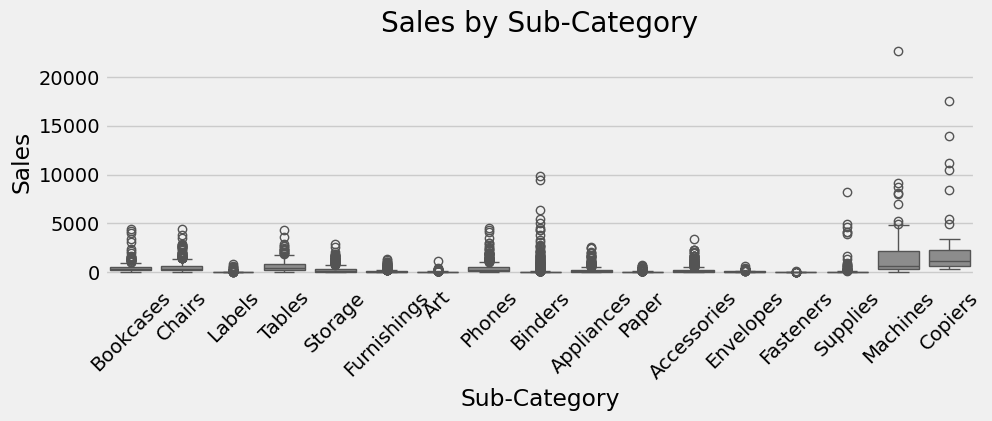

In [122]:
# Sales by Sub-Category
fig, ax = plt.subplots(figsize=(10, 3))
sns.boxplot(data=data_original, x='Sub-Category', y='Sales', ax=ax, color=col_pal[7])
ax.set_title('Sales by Sub-Category')
plt.ylabel('Sales')
plt.xlabel('Sub-Category')
plt.xticks(rotation=45)
plt.show()

In [123]:
# Create features for train and test sets
train = create_features(train)
test = create_features(test)
x_train = train[features]
y_train = train[target]
x_test = test[features]
y_test = test[target]

In [124]:
# Train the XGBoost model
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.001)
reg.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)], verbose=100)

[0]	validation_0-rmse:2241.58676	validation_1-rmse:2451.56564
[100]	validation_0-rmse:2178.39802	validation_1-rmse:2434.82695
[200]	validation_0-rmse:2121.25741	validation_1-rmse:2417.07035
[300]	validation_0-rmse:2069.43348	validation_1-rmse:2402.73700
[400]	validation_0-rmse:2020.56301	validation_1-rmse:2387.13776
[500]	validation_0-rmse:1975.68701	validation_1-rmse:2377.66177
[600]	validation_0-rmse:1934.18062	validation_1-rmse:2374.28814
[700]	validation_0-rmse:1897.04190	validation_1-rmse:2373.74657
[706]	validation_0-rmse:1894.92287	validation_1-rmse:2373.76683


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

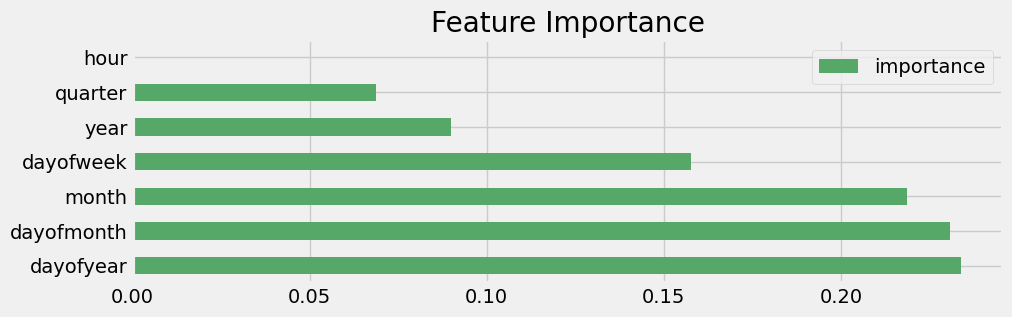

In [125]:
# Plot feature importance to understand the impact of each feature
f1 = pd.DataFrame(data=reg.feature_importances_, index=reg.feature_names_in_, columns=['importance'])
f1.sort_values('importance', ascending=False, inplace=True)
f1.plot(kind='barh', figsize=(10, 3), color=col_pal[2])
plt.title('Feature Importance')
plt.show()


In [126]:
# Predict on the test set
test['predictions'] = reg.predict(x_test)

In [127]:
test.head()

,Sales,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,predictions
Order Date,,,,,,,,,
2018-01-01,1481.828,0,0,1,1,2018,1,1,1228.636475
2018-01-02,2079.554,0,1,1,1,2018,2,2,1401.812500
2018-01-03,2070.272,0,2,1,1,2018,3,3,1275.113403
2018-01-06,33.740,0,5,1,1,2018,6,6,1238.666138
2018-01-07,3395.590,0,6,1,1,2018,7,7,1250.224609


In [128]:
# Merge predictions with the original data
data = data.merge(test[['predictions']], how='left', left_index=True, right_index=True)

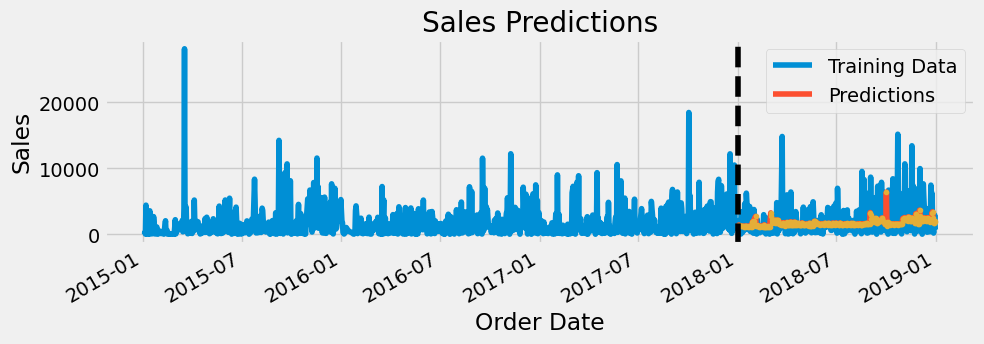

In [129]:
# Plot actual vs. predicted sales to visualize the model performance
ax = data[['Sales', 'predictions']].plot(figsize=(10, 3))
data['predictions'].plot(ax=ax, style='.')
ax.axvline('2018-01-01', color='black', ls='--')
ax.set_title('Sales Predictions')
ax.set_ylabel('Sales')
ax.legend(['Training Data', 'Predictions'])
plt.show()

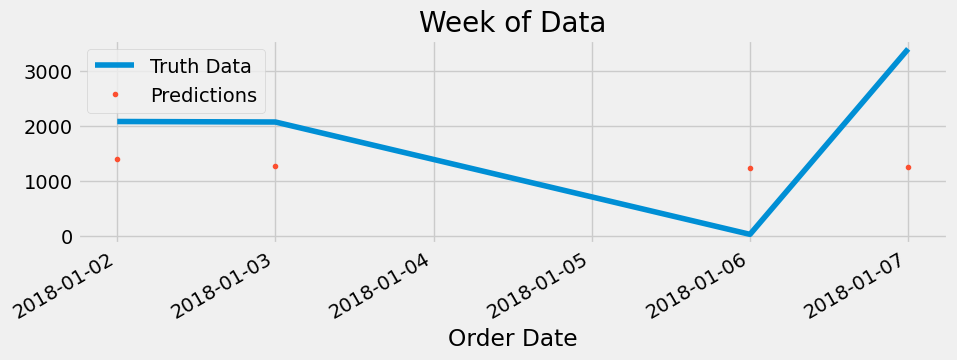

In [130]:
# Plot a week of actual vs. predicted sales for a closer look
ax = data.loc[(data.index > '2018-01-01') & (data.index < '2018-01-08')]['Sales'].plot(figsize=(10, 3), title='Week of Data')
data.loc[(data.index > '2018-01-01') & (data.index < '2018-01-08')]['predictions'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
plt.show()